# IHLT Final Project: Semantic Textual Similarity Project

Jordi Armengol, Joan Llop

This projects consists of a Semantic Textual Similarity exercise from the SemEval (Semantic Evaluation Exercises). Specifically, we will use the dataset from SemEval 2012, and compare ourselves with the participants of that workshop. Basically, we will use the classical NLP and machine learning techniques that we have used, mostly with lexical features, but also experimenting with syntactic information. Additionally, we will provide some transfer learning (deep learning) alternatives.

# Data collection
We start by downloading the SemEval 2012 dataset.

In [10]:
%%time
!mkdir -p data
!wget https://gebakx.github.io/ihlt/sts/resources/train.tgz --directory-prefix=data
!wget https://gebakx.github.io/ihlt/sts/resources/test-gold.tgz --directory-prefix=data
%cd data
!tar zxvf train.tgz
!tar zxvf test-gold.tgz
%cd ..

--2019-12-12 04:43:10--  https://gebakx.github.io/ihlt/sts/resources/train.tgz
Resolving gebakx.github.io (gebakx.github.io)... 185.199.111.153, 185.199.110.153, 185.199.109.153, ...
Connecting to gebakx.github.io (gebakx.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125822 (123K) [application/octet-stream]
Saving to: ‘data/train.tgz.16’

train.tgz.16        100%[===================>] 122,87K  --.-KB/s    in 0,09s   

2019-12-12 04:43:10 (1,27 MB/s) - ‘data/train.tgz.16’ saved [125822/125822]

--2019-12-12 04:43:10--  https://gebakx.github.io/ihlt/sts/resources/test-gold.tgz
Resolving gebakx.github.io (gebakx.github.io)... 185.199.111.153, 185.199.109.153, 185.199.110.153, ...
Connecting to gebakx.github.io (gebakx.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118094 (115K) [application/octet-stream]
Saving to: ‘data/test-gold.tgz.16’

test-gold.tgz.16    100%[=================

## Corpus assembly
Train and test sets. The test set will not be used for learning or model selection.

In [11]:
%%time
import os
import numpy as np
train_files = ['MSRpar', 'MSRvid', 'SMTeuroparl']
train_data = []
train_labels = []
for file in train_files:
    with open(os.path.join('data', 'train', 'STS.input.' + file + '.txt'), 'r') as f:
        train_data += [sent.split('\t') for sent in f.readlines()]
    with open(os.path.join('data', 'train', 'STS.gs.' + file + '.txt'), 'r') as f:
        train_labels += [float(num) for num in f.readlines()]
train_data = np.array(train_data)
train_labels = np.array(train_labels)

test_files = ['MSRpar', 'MSRvid', 'SMTeuroparl', 'surprise.OnWN', 'surprise.SMTnews']
test_data = []
test_labels = []
for file in test_files:
    with open(os.path.join('data', 'test-gold', 'STS.input.' + file + '.txt'), 'r') as f:
        test_data += [sent.split('\t') for sent in f.readlines()]
    with open(os.path.join('data', 'test-gold', 'STS.gs.'+ file + '.txt'), 'r') as f:
        test_labels += [float(num) for num in f.readlines()]
test_data = np.array(test_data)
test_labels = np.array(test_labels)

CPU times: user 26.7 ms, sys: 0 ns, total: 26.7 ms
Wall time: 28 ms


## Alternative 1: Classical NLP and machine learning

## Preliminary experiments for preprocessing and feature selection issues
Before applying the final preprocessing and feature extraction, we performed a series of previous experiments for gaining some insights on the importance of certain preprocessing and feature extraction decisions.


## General class/interface
There are so many things to try that we will start by defining a general class/interface for all the models that we will use. This class has, among other features, a cross-validation method (obviously, using only the train set, not the test set). The models will inherit the methods of this class and, essentially, they will only have to implement the a method from extracting the features from data. Notice that the Model class is very generic, but complete. Specifically, it has a method for **cross-validation**, which takes the train set and divided it in different folds (K-Fold Cross-Validation).

In [12]:
import pickle
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats
import sklearn

class Model:
    def __init__(self,  x, y, regr=LinearRegression(),):
        self.regr = regr
        self.x_features = self._extract_features(x)
        self.y = y
        self.name = None
        self.description = None
    
    
    def save(self):
        pickle.dump(self, open(self.name + '.model', 'wb').write())
    
    @classmethod
    def load(cls, name):
        return pickle.load(open(self.name + '.model', 'rb').read())
        
    
    def _extract_features(self, x):
        raise NotImplementedError 
    
    def fit(self, x, y):
        self.x_features = self._extract_features(x)
        self.y = y
        self.regr.fit(self.x_features, self.y)
    
    
    def predict(self, new_x):
        new_x_features = self._extract_features(new_x)
        return self.regr.predict(new_x_features)
        
        
    def evaluate(self, true_labels, predicted_labels):
        pearson, p_value = stats.pearsonr(true_labels, predicted_labels)
        return pearson, p_value
    
    
    def cross_validate(self, n_folds=5, seed=1):
        assert self.x_features is not None
        kf = sklearn.model_selection.KFold(n_splits=n_folds, random_state=seed)
        average_pearson = 0
        for train_index, val_index in kf.split(self.x_features):
            X_train, X_val = self.x_features[train_index], self.x_features[val_index]
            y_train, y_val = self.y[train_index], self.y[val_index]
            self.regr.fit(X_train, y_train)
            predicted_labels = self.regr.predict(X_val)
            pearson, _ = self.evaluate(y_val, predicted_labels)
            average_pearson += abs(pearson)
        return average_pearson/n_folds

### Jaccard distance of some basic features
In this initial approach, we use the jaccard distance to compute the similarity between different classical features studied in class: lemmas, most common synsets,  and part-of-Speech, length of word and whether the word is a digit. We experimented with different preprocessing strategies as well, like filtering stop words.

In [15]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk import pos_tag
from nltk.metrics import jaccard_distance
from nltk.corpus import stopwords

class JaccardModel(Model):
    
    
    def __init__(self, *kwargs):
        self.name = 'JaccardModel'
        self.description = 'Jaccard distance, some basic features'
        self.stop_words = set(stopwords.words('english')) 
        super().__init__(*kwargs)
        
    def _extract_features(self, x):
        def preprocess(sent):
            preprocessed = ""
            for char in sent:
                if char.isdigit():
                    preprocessed += char
                elif char.isalpha():
                    preprocessed += char.lower()
                elif char == ' ':
                    preprocessed += char

            return str(preprocessed)

        x = [[preprocess(sent1), preprocess(sent2)] for sent1, sent2 in x]
        
        def lemmatize(token, pos):
            if pos in {'N','V'}:
                return wnl.lemmatize(token.lower(), pos.lower())
            return token.lower()


        def nltk_pos_to_wordnet_pos(nltk_pos):
            mapping = {'NN': wn.NOUN, 'JJ': wn.ADJ, 'VB': wn.VERB, 'RB': wn.ADV}
            if nltk_pos in mapping:
                return mapping[nltk_pos]
            else:
                return None


        def get_synsets(sent):
            saved_synsets = []
            tokens = word_tokenize(sent)
            pos_tags = pos_tag(tokens)
            lemmas = [lemmatize(t, pos) for t, pos in zip(tokens, pos_tags)]
            for token, pos, lemma in zip(tokens, pos_tags, lemmas):
                wordnet_pos = nltk_pos_to_wordnet_pos(pos[1])
                if wordnet_pos is not None:
                    word_synsets = wn.synsets(lemma, wordnet_pos)
                    if len(word_synsets) > 0:
                        most_freq_synset = word_synsets[0] # The most frequent synset is the first one
                        saved_synsets.append(most_freq_synset)
            return saved_synsets


        def get_features_from_word(sent, index, pos):
            word = sent[index]
            features = []
            features.append(str(pos)) # Part-of-Speech                   
            features.append(str(len(word))) # length of word
            features.append(str(index==0)) # beggining of a sentence
            features.append(str(index==len(sent)-1)) # end of sentence
            features.append(str(word.isdigit())) # is a digit
            return features

        def sent2features(sent):
            features = []
            tokens = [word for word in word_tokenize(sent) if not word in self.stop_words]
            features.append(tokens)
            pos_tags = pos_tag(tokens)
            features.append(pos_tags)
            lemmas = [lemmatize(t, pos) for t, pos in zip(tokens, pos_tags)]
            features.append(lemmas)
            synsets = get_synsets(sent)
            if len(synsets) > 0:
                features.append(synsets)
            else:
                features.append([0])
            temp_f = []
            for i in range(len(tokens)):
                temp_f += get_features_from_word(tokens, i, pos_tags[i])
            features.append(temp_f)

            return features
        
        def distance(features1, features2, sent1, sent2, index):
            distances = []
            init = True
            for f1, f2 in zip(features1, features2):
                distances.append(jaccard_distance(set(f1), set(f2)))
            return distances

        
        pairs_of_features = [(sent2features(sent1), sent2features(sent2)) for sent1, sent2 in x]
        distances = np.array([distance(features1, features2, sent1, sent2, index) for index, ((features1, features2), (sent1, sent2)) in enumerate(zip(pairs_of_features, x))])
        return distances
    
    
jaccardModel = JaccardModel(train_data, train_labels)
jaccardModel.cross_validate()

0.5744670790260961

### Using words
Cosine similarity of the union of the sets of words.

In [16]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk import pos_tag
import numpy as np
from nltk.corpus import stopwords 
from nltk.metrics import jaccard_distance
from string import punctuation

class BagWordsModel(Model):
    
    
    def __init__(self, *kwargs):
        self.name = 'BagWords'
        self.description = 'We get a set of words of both setences, \
        calculate the union, get the count of each word of the union for each sentence \
        and get the cosine similarity'
        self.stop_words = set(stopwords.words('english'))
        super().__init__(*kwargs)
    
        
    def _extract_features(self, x):
        def preprocess(data):
            processed_data = []
            for sent1, sent2 in data:
                sent1 = sent1.lower()
                sent2 = sent2.lower()
                processed_sent1 = ""
                processed_sent2 = ""
                for char in sent1: 
                    if char.isalnum() or char == ' ': 
                        processed_sent1 += char
                for char in sent2: 
                    if char.isalnum() or char == ' ': 
                        processed_sent2 += char
                processed_data.append([processed_sent1, processed_sent2])
            return processed_data
        
        
        def cosine_similarity(a, b):
            cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
            return cos_sim
        
        
        def get_bag_of_words(sent1, sent2):
            tokens1 = [word for word in word_tokenize(sent1) if not word in self.stop_words]
            tokens2 = [word for word in word_tokenize(sent2) if not word in self.stop_words]
            union = np.union1d(tokens1, tokens2)
            count1 = np.zeros(len(union))
            count2 = np.zeros(len(union))
            for token in tokens1:
                count1[np.where(union == token)] += 1
            for token in tokens2:
                count2[np.where(union == token)] += 1
            return [cosine_similarity(count1, count2)]
        
        preprocessed_x = preprocess(x)
        BoW = np.array([get_bag_of_words(sent1, sent2) for sent1, sent2 in preprocessed_x])
        return BoW

bagWordsModel = BagWordsModel(train_data, train_labels)
bagWordsModel.cross_validate()

0.5968105783849428

### Using of lemmas
Same as before, but with lemmas. Recall that we are still using a linear regression.

In [18]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk import pos_tag
import numpy as np
from nltk.corpus import stopwords 
from nltk.metrics import jaccard_distance


class BagLemmasModel(Model):
    
    
    def __init__(self, *kwargs):
        self.name = 'BagLemmasModel'
        self.description = 'We get the bag of lemmas of both setences, calculate the union,\
        get the count of each word of the union for each sentence and get the cosine distance \
        between them'
        self.stop_words = set(stopwords.words('english'))
        self.wnl = WordNetLemmatizer()
        super().__init__(*kwargs)
    
        
    def _extract_features(self, x):
        def preprocess(data):
            processed_data = []
            for sent1, sent2 in data:
                sent1 = sent1.lower()
                sent2 = sent2.lower()
                processed_sent1 = ""
                processed_sent2 = ""
                for char in sent1: 
                    if char.isalnum() or char == ' ': 
                        processed_sent1 += char 
                for char in sent2: 
                    if char.isalnum() or char == ' ': 
                        processed_sent2 += char
                processed_data.append([processed_sent1, processed_sent2])
            return processed_data
        
        
        def cosine_similarity(a, b):
            cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
            return cos_sim
        
        
        def get_cosine_of_frequencies(vec1, vec2):
            union = np.union1d(vec1, vec2)
            count1 = np.zeros(len(union))
            count2 = np.zeros(len(union))
            for elem in vec1:
                count1[np.where(union == elem)] += 1
            for elem in vec2:
                count2[np.where(union == elem)] += 1
            return [cosine_similarity(count1, count2)]
        
        
        def lemmatize(token):
            return self.wnl.lemmatize(token)
        
        
        def get_bag_of_lemmas(sent1, sent2):
            tokens1 = [word for word in word_tokenize(sent1) if not word in self.stop_words]
            tokens2 = [word for word in word_tokenize(sent2) if not word in self.stop_words]
            lemmas1 = [lemmatize(word) for word in tokens1]
            lemmas2 = [lemmatize(word) for word in tokens2]
            return get_cosine_of_frequencies(lemmas1, lemmas2)
                
            
        preprocessed_x = preprocess(x)
        BoW = np.array([get_bag_of_lemmas(sent1, sent2) for sent1, sent2 in preprocessed_x])
        return BoW

bagLemmasModel = BagLemmasModel(train_data, train_labels)
bagLemmasModel.cross_validate()

0.6076451713539923

### Using stems
Similar to our previous approach, but in this case we decided to experiment with stems instead of lemmas. Remarkably, stems performed better than lemmas, which is counter-intuitive if we take into account the theoretical foundations of lemmas (instead of heuristic-driven, lemmas are the canonical form of a word that we find in a dictionary, so we thought that they should have worked better; it was not the case). Recall that we are still using a linear regression.


In [21]:
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet as wn
from nltk import pos_tag
import numpy as np
from nltk.corpus import stopwords 
from nltk.metrics import jaccard_distance


class BagStemsModel(Model):
    
    
    def __init__(self, *kwargs):
        self.name = 'BagStemsModel'
        self.description = 'We get the bag of stems of both setences, calculate the union, \
        get the count of each word of the union for each sentence and get the cosine distance between them'
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()
        super().__init__(*kwargs)
    
        
    def _extract_features(self, x):
        def preprocess(data):
            processed_data = []
            for sent1, sent2 in data:
                sent1 = sent1.lower()
                sent2 = sent2.lower()
                processed_sent1 = ""
                processed_sent2 = ""
                for char in sent1: 
                    if char.isalnum() or char == ' ': 
                        processed_sent1 += char
                for char in sent2: 
                    if char.isalnum() or char == ' ': 
                        processed_sent2 += char
                processed_data.append([processed_sent1, processed_sent2])
            return processed_data
        
        
        def cosine_similarity(a, b):
            cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
            return cos_sim
        
        
        def get_cosine_of_frequencies(vec1, vec2):
            union = np.union1d(vec1, vec2)
            count1 = np.zeros(len(union))
            count2 = np.zeros(len(union))
            for elem in vec1:
                count1[np.where(union == elem)] += 1
            for elem in vec2:
                count2[np.where(union == elem)] += 1
            return [cosine_similarity(count1, count2)]
        
        
        def stemmatize(token):
            return self.stemmer.stem(token)
        
        
        def get_bag_of_stems(sent1, sent2):
            tokens1 = [word for word in word_tokenize(sent1) if not word in self.stop_words]
            tokens2 = [word for word in word_tokenize(sent2) if not word in self.stop_words]
            stems1 = [stemmatize(word) for word in tokens1]
            stems2 = [stemmatize(word) for word in tokens2]
            return get_cosine_of_frequencies(stems1, stems2)                
            
            
        preprocessed_x = preprocess(x)
        BoW = np.array([get_bag_of_stems(sent1, sent2) for sent1, sent2 in preprocessed_x])
        return BoW

bagStemsModel = BagStemsModel(train_data, train_labels)
bagStemsModel.cross_validate()

0.6488292812545408

### Bigrams vector representation
We compute the cosine similarity of a frequency bigram representation of the sentences. Cosine similarity is the canonical measure for comparing vectors. We decided to use a bigram representations because bigrams provide slightly more context (local context of size = 1, apart from the token itself) than just using unigrams. In the literature, some approaches have studied the use of n-grams for textual similarity.


In [20]:
import numpy as np
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer


class BiGramsModel(Model):
    
    
    def __init__(self, *kwargs):
        self.name = 'BiGramsModel'
        self.description = 'BiGramsModel'
        self.allowed = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', \
                                 '(', ')', '.', ' ', '!', '?', 'a', 'b', 'c', 'd', 'e', \
                                 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', \
                                 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])
        self.not_allowed_words = set(stopwords.words('english'))
        self.stemmer = SnowballStemmer("english")
        super().__init__(*kwargs)
    
        
    def _extract_features(self, x):
        def get_allowed_characters(sent):
            sent = sent.lower()
            tokens = [word for word in word_tokenize(sent) if not word in self.not_allowed_words]
            stems = [self.stemmer.stem(word) for word in tokens]
            new_sent = " ".join(stems)
            return "".join([char for char in new_sent if char in self.allowed])
        
        
        def preprocess(data):
            word_freq = {}
            processed_data = []
            for sent1, sent2 in data:
                allowed_chars1 = get_allowed_characters(sent1)
                allowed_chars2 = get_allowed_characters(sent2)
                processed_data.append([allowed_chars1, allowed_chars2])
            return processed_data
        
        
        def cosine_similarity(a, b):
            cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
            return cos_sim
        
        
        def get_vector_bigrams(sent):
            count = np.zeros(len(self.allowed)**2) # number of possible bigrams
            for i in range(len(sent)-1):
                idx_f = int(np.where(self.allowed == sent[i])[0])
                idx_s = int(np.where(self.allowed == sent[i+1])[0])
                count[idx_f*len(self.allowed) + idx_s] += 1
            return count
            
                
        def get_cos_of_bigrams(sent1, sent2):
            return [cosine_similarity(get_vector_bigrams(sent1), get_vector_bigrams(sent2))]                
            
            
        preprocessed_x = preprocess(x)
        BiGms = np.array([get_cos_of_bigrams(sent1, sent2) for sent1, sent2 in preprocessed_x])
        return BiGms

biGramsModel = BiGramsModel(train_data, train_labels)
biGramsModel.cross_validate()

0.6637117020982714

### Synsets
We apply the same algorithm as in the case of words and lemmas, but with synsets and lemmas. Synsets have the theoretical adva. In practice, they do not work very well because most of the tokens do not have an assigned synset, and we do not perform word sense disambiguation (we retrieve the most sfrequent synset, not the relevant synset depending on the context, which would require a specific NLP application).


In [145]:
import numpy as np
from functools import reduce
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer

class SynsetsLemmasModel(Model):
    
    
    def __init__(self, *kwargs):
        self.name = 'SynsetsLemmasModel'
        self.description = 'SynsetsLemmasModel'
        super().__init__(*kwargs)
    
        
    def _extract_features(self, x):
        
        def cosine_similarity(a, b):
            cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
            return cos_sim
        
        
        def get_cosine_of_frequencies(vec1, vec2):
            union = np.union1d(vec1, vec2)
            count1 = np.zeros(len(union))
            count2 = np.zeros(len(union))
            for elem in vec1:
                count1[np.where(union == elem)] += 1
            for elem in vec2:
                count2[np.where(union == elem)] += 1
            return [cosine_similarity(count1, count2)]
        
        
        def get_union_SynLemmas(word):
            synsets = wordnet.synsets(word)
            if len(synsets) > 0:
                return reduce(np.union1d, ([str(lemma.name()) for lemma in synsets[0].lemmas()]))
            return np.empty(0)
        
        
        def get_sentence_union_synsets(tokens):
            return reduce(np.union1d, ([get_union_SynLemmas(word) for word in tokens]))
        
        
        def get_union_synsets(sent1, sent2):
            synsets1 = get_sentence_union_synsets(word_tokenize(sent1))
            synsets2 = get_sentence_union_synsets(word_tokenize(sent2))
            return get_cosine_of_frequencies(synsets1, synsets2)
            
        
        BoW = np.array([get_union_synsets(sent1, sent2) for sent1, sent2 in x])
        return BoW

synsetsLemmasModel = SynsetsLemmasModel(train_data, train_labels)
synsetsLemmasModel.cross_validate()

0.4602791132967097

### Noun phrases and verbs comparison
Spacy is a NLP toolkit similar to Stanford CoreNLP, but without requiring a Java server. We will use it to retrieve noun phrases and verbs.

In [24]:
# !python3 -m pip install spacy --user
# !python3 -m spacy download en_core_web_sm --user

In [25]:
import numpy as np
import spacy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize
import math


class NounPhraseModel(Model):
    
    
    def __init__(self, *kwargs):
        self.name = 'NounPhraseModel'
        self.description = 'NounPhraseModel'
        # Load English tokenizer, tagger, parser, NER and word vectors
        self.nlp = spacy.load("en_core_web_sm")
        self.not_allowed_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()
        super().__init__(*kwargs)
    
        
    def _extract_features(self, x):
        
        
        def get_distance(v1, v2):
            if not v1 or not v2: return 0
            count_pairs = 0
            for sent1 in v1:
                for sent2 in v2:
                    if sent1 in sent2 or sent2 in sent1:
                        count_pairs += 1
            return count_pairs/max(len(v1), len(v2))
        
        
        def get_noun_phrases(sent):
            doc = self.nlp(sent)
            noun_phrases = [chunk.text for chunk in doc.noun_chunks]
            return noun_phrases
        
        
        def get_verbs(sent):
            doc = self.nlp(sent)
            verbs = [token.lemma_ for token in doc if token.pos_ == "VERB"]
            return verbs
        
        
        def get_name_entities(sent):
            doc = self.nlp(sent)
            ne = [entity.text for entity in doc.ents]
            return ne
        
        def get_similarity(sent1, sent2):
            noun_phrases_1 = get_noun_phrases(str(sent1))
            noun_phrases_2 = get_noun_phrases(str(sent2))
            verbs1 = get_verbs(str(sent1))
            verbs2 = get_verbs(str(sent2))
            ne1 = get_name_entities(str(sent1))
            ne2 = get_name_entities(str(sent2))
            dist_nouns = get_distance(noun_phrases_1, noun_phrases_2)
            dist_verbs = get_distance(verbs1, verbs2)
            dist_ne = get_distance(ne1, ne2)
            return [dist_verbs, dist_nouns, dist_ne]
        
        
        
        sm = np.array([get_similarity(sent1, sent2) for sent1, sent2 in x])
        return sm

nounPhraseModel = NounPhraseModel(train_data, train_labels)
nounPhraseModel.cross_validate()

0.4953711707706738

**Preliminary conclusions**
Let us do a summary of what have been experimented with. So far, we have tested many features, still with linear regression. There are many tests that we do not include here, for brevity (eg. the same models but without removing stop words, which gave a worse result). 

Now, are going to aggregate some features into a single model. The assumption here is that their contribution will be additive or at least will not damage the result. As preliminary research, we conducted some experiments on some of the combinations, but for brevity and computational constraints is not possible to test all the combinations. Instead, we will include the features that seemed the most promising. In the case of the NounPhraseModel, for instance, we will not include it, because it is way slower than the other ones and the obtained results were mediocre. We will ignore synsets as well, for not giving very good results.

On the other hand, we will add some other features that we experimented with but did not include for brevity: edit distance (it won't correlate with semantic similarity, but non-linear models can realize that a very short edit distance means that the sentence is almost literally equal). 

Also, we are going to consider trigrams, in addition to bigrams, and different ways of representing the frequencies (a simple boolean bag of words, a frequency distribution or Inverse Document Frequency).

Notice that we use stems instead of lemmas because they empirically behaved better in the preliminary experiments. We replace words by stems for reducing the vocabulary. We experimented with replacing named entities by their tags as well, but it did not obtain promising results when cross-validating.


## Final preprocessing and feature engineering

### Preprocessing and tagging

In [138]:
%%time
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk import pos_tag
from nltk import ne_chunk
from nltk.stem import PorterStemmer

stopwords_set = set(stopwords.words('english')) 
stemmer = PorterStemmer()

def preprocess(X):
    def is_number(s):
        try:
            x = float(s)
            return True
        except ValueError:
            return False

    def characters_not_punct(token):
        for c in token:
            if c in punctuation:
                return False
        return True
    
    def lemmatize(token, pos):
        if pos in {'N','V'}:
            return wnl.lemmatize(token.lower(), pos.lower())
        return token.lower()
    
    def stemmatize(token):
            return stemmer.stem(token)

    def nltk_pos_to_wordnet_pos(nltk_pos):
        mapping = {'NN': wn.NOUN, 'JJ': wn.ADJ, 'VB': wn.VERB, 'RB': wn.ADV}
        if nltk_pos in mapping:
            return mapping[nltk_pos]
        else:
            return None
    
    def get_synset(lemma, pos):
        wordnet_pos = nltk_pos_to_wordnet_pos(pos[1])
        if wordnet_pos is not None:
            word_synsets = wn.synsets(lemma, wordnet_pos)
            if len(word_synsets) > 0:
                most_freq_synset = word_synsets[0] # The most frequent synset is the first one
                return most_freq_synset
        return None
    
    def get_nes(pos_tags):
        nes = ne_chunk(pos_tags, binary=False)
        nes_map = []
        for tree_element in nes:
            if type(tree_element) == nltk.tree.Tree:
                for element in tree_element:
                        nes_map.append(tree_element.label())
            else:
                nes_map.append(None)
        return nes_map
                
    def preprocess_sentence(sent):
        tokens = word_tokenize(sent)
        pos_tags = pos_tag(tokens)
        clean_tokens = []
        synsets = set([])
        chars = ''.join([c for c in sent if c not in punctuation + ' '])
        nes_map = get_nes(pos_tags)
        for token, pos, ne in zip(tokens, pos_tags, nes_map):
#             token = token.lower()
#             if ne is not None:
#                 token = ne
#                 clean_tokens.append(token)
#             lemma = lemmatize(token, pos)
#             clean_tokens.append(lemma)
            stem = stemmatize(token)
            clean_tokens.append(stem)
#             synset = get_synset(lemma, pos)
#             if synset is not None:
#                 synsets.add(synset)
        return clean_tokens, synsets, chars

    clean_tokens = []
    synsets = []
    chars = []
    nes = []
    for sent1, sent2 in X:
        tok1, syn1, ch1 = preprocess_sentence(sent1)
        tok2, syn2, ch2 = preprocess_sentence(sent2)
        clean_tokens.append((tok1, tok2))
        synsets.append((syn1, syn2))
        chars.append((ch1, ch2))
        
    return clean_tokens, synsets, chars

preprocessed_tokens_train, synsets_train, chars_train = preprocess(train_data)
preprocessed_tokens_test, synsets_test, chars_test = preprocess(test_data)

CPU times: user 50.4 s, sys: 168 ms, total: 50.6 s
Wall time: 50.6 s


### Feature extraction: Text representation and distances

In [183]:
%%time
from nltk.metrics.distance import edit_distance
from nltk.metrics import jaccard_distance
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import pandas as pd
from collections import OrderedDict
import warnings
warnings.filterwarnings("ignore")
import math


def cosine_similarity(a, b):
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim

def overlap(A, B):
    return len(A.intersection(B))/(min(len(A), len(B)))

def set_kernel_distance(a, b):
    return np.exp2(np.dot(a, b.T))

def get_features(preprocessed_tokens, synsets, chars):
    
    def build_bow(sequences, method, chars=False, ngram_range=(1,1)):
        assert method in ['bow', 'tf', 'tf_idf']
        if not chars:
            corpus = [' '.join(tokens1) + ' '.join(tokens2) for tokens1, tokens2 in sequences]
            analyzer = 'word'
        else:
            corpus = [' '.join(list(chars1)) + ' '.join(list(chars2)) for chars1, chars2 in sequences]
            analyzer = 'char'
        if method == 'bow':
            cv = CountVectorizer(binary=True, analyzer=analyzer, ngram_range=ngram_range)
        elif method == 'tf':
            cv = CountVectorizer(binary=False, analyzer=analyzer, ngram_range=ngram_range)
        else:
            cv = TfidfVectorizer()
        cv.fit(corpus)
        return cv
    bow_tokens = build_bow(preprocessed_tokens, 'bow')
    tf_tokens = build_bow(preprocessed_tokens, 'tf')
    tf_idf_tokens = build_bow(preprocessed_tokens, 'tf_idf')
    bow_chars = build_bow(chars, 'bow', chars=True)
    tf_chars = build_bow(chars, 'tf', chars=True)
    tf_idf_chars = build_bow(chars, 'tf_idf', chars=True)
    bow_bigrams = build_bow(preprocessed_tokens, 'bow', (2, 2))
    tf_bigrams = build_bow(preprocessed_tokens, 'tf', (2, 2))
    bow_trigrams = build_bow(preprocessed_tokens, 'bow', (3, 3))
    tf_trigrams = build_bow(preprocessed_tokens, 'tf', (3, 3))
    def feature_encoder(tokens, synsets, chars,
                        bow_tokens=bow_tokens, tf_tokens=tf_tokens, tf_idf_tokens=tf_idf_tokens,
                        bow_chars=bow_chars, tf_chars=tf_chars, tf_idf_chars=tf_idf_chars,
                        bow_bigrams=bow_bigrams,tf_bigrams=tf_bigrams,
                        bow_trigrams=bow_trigrams, tf_trigrams=tf_trigrams):
                toks1, toks2 = tokens
                syns1, syns2 = synsets
                chars1, chars2 = chars
                
                # encoding
                encoded_bow_tokens = np.concatenate((bow_tokens.transform([' '.join(toks1)]).toarray(),
                                                     bow_tokens.transform([' '.join(toks2)]).toarray())).flatten()
                encoded_tf_tokens = np.concatenate((tf_tokens.transform([' '.join(toks1)]).toarray(),
                                                     tf_tokens.transform([' '.join(toks2)]).toarray())).flatten()
                encoded_tf_idf_tokens = np.concatenate((tf_idf_tokens.transform([' '.join(toks1)]).toarray(),
                                                     tf_idf_tokens.transform([' '.join(toks2)]).toarray())).flatten()
                encoded_bow_chars = np.concatenate((bow_chars.transform([' '.join(chars1)]).toarray(),
                                                     bow_chars.transform([' '.join(chars2)]).toarray())).flatten()
                encoded_tf_chars = np.concatenate((tf_chars.transform([' '.join(chars1)]).toarray(),
                                                     tf_chars.transform([' '.join(chars2)]).toarray())).flatten()
                encoded_tf_idf_chars = np.concatenate((tf_idf_chars.transform([' '.join(chars1)]).toarray(),
                                                     tf_idf_chars.transform([' '.join(chars2)]).toarray())).flatten()
                encoded_bow_bigrams = np.concatenate((bow_chars.transform([' '.join(toks1)]).toarray(),
                                                     bow_chars.transform([' '.join(toks2)]).toarray())).flatten()
                encoded_tf_bigrams = np.concatenate((tf_chars.transform([' '.join(toks1)]).toarray(),
                                                     tf_chars.transform([' '.join(toks2)]).toarray())).flatten()
                encoded_bow_trigrams = np.concatenate((bow_chars.transform([' '.join(toks1)]).toarray(),
                                                     bow_chars.transform([' '.join(toks2)]).toarray())).flatten()
                encoded_tf_trigrams = np.concatenate((tf_chars.transform([' '.join(toks1)]).toarray(),
                                                     tf_chars.transform([' '.join(toks2)]).toarray())).flatten()
                
                                                     
                # distances
                edit_dist = edit_distance(chars1, chars2)
                set_dist_encoded_bow_tokens = set_kernel_distance(
                    encoded_bow_tokens[:encoded_bow_tokens.shape[0]//2],
                    encoded_bow_tokens[encoded_bow_tokens.shape[0]//2:])
                cos_encoded_tf_tokens = cosine_similarity(
                    encoded_tf_tokens[:encoded_tf_tokens.shape[0]//2],
                    encoded_tf_tokens[encoded_tf_tokens.shape[0]//2:])
                cos_encoded_tf_idf_tokens = cosine_similarity(
                    encoded_tf_idf_tokens[:encoded_tf_idf_tokens.shape[0]//2],
                    encoded_tf_idf_tokens[encoded_tf_idf_tokens.shape[0]//2:])
                cos_encoded_tf_chars = cosine_similarity(
                    encoded_tf_chars[:encoded_tf_chars.shape[0]//2],
                    encoded_tf_chars[encoded_tf_chars.shape[0]//2:])
                set_dist_encoded_bow_bigrams = set_kernel_distance(
                    encoded_bow_bigrams[:encoded_bow_bigrams.shape[0]//2],
                    encoded_bow_bigrams[encoded_bow_bigrams.shape[0]//2:])
                cos_encoded_tf_bigrams = cosine_similarity(
                    encoded_tf_bigrams[:encoded_tf_bigrams.shape[0]//2],
                    encoded_tf_bigrams[encoded_tf_bigrams.shape[0]//2:])
                set_dist_encoded_bow_trigrams = set_kernel_distance(
                    encoded_bow_trigrams[:encoded_bow_trigrams.shape[0]//2],
                    encoded_bow_trigrams[encoded_bow_trigrams.shape[0]//2:])
                cos_encoded_tf_trigrams = cosine_similarity(
                    encoded_tf_trigrams[:encoded_tf_trigrams.shape[0]//2],
                    encoded_tf_trigrams[encoded_tf_trigrams.shape[0]//2:])
                
                                                      
                toks1_set, toks2_set = set(toks1), set(toks2)
                if len(toks1_set) > 0 and len(toks2_set) > 0:
                    tok_jaccard = jaccard_distance(set(toks1), set(toks2))
                    tok_overlap = overlap(set(toks1), set(toks2))
                else:
                    tok_jaccard = 1
                    tok_overlap = 1
                if len(chars1) > 0 and len(chars2) > 0:
                    chars_jaccard = jaccard_distance(set(list(chars1)), set(list(chars2)))
                    chars_overlap = overlap(set(list(chars1)), set(list(chars2)))
                else:
                    chars_jaccard = 1
                    chars_overlap = 1
                return OrderedDict(
                           edit_dist=edit_dist, 
                           set_dist_encoded_bow_tokens=set_dist_encoded_bow_tokens,
                           cos_encoded_tf_idf_tokens=cos_encoded_tf_idf_tokens,
                           cos_encoded_tf_chars=cos_encoded_tf_chars,
                           set_dist_encoded_bow_bigrams=set_dist_encoded_bow_bigrams,
                           cos_encoded_tf_bigrams=cos_encoded_tf_bigrams,
                           set_dist_encoded_bow_trigrams=set_dist_encoded_bow_trigrams,
                           cos_encoded_tf_trigrams=cos_encoded_tf_trigrams,
                           tok_jaccard=tok_jaccard,
                           tok_overlap=tok_overlap,    
                           chars_jaccard=chars_jaccard,
                           chars_overlap=chars_overlap
                            )                      
                
    features = []
    for toks, syns, ch in zip(preprocessed_tokens, synsets, chars):
        feat = feature_encoder(toks, syns, ch)
        features.append(feat)
    mat_features = pd.DataFrame(features).values
    std_scaler = StandardScaler().fit(mat_features)
    def scale(features_row, scaler=std_scaler):
        scaled = scaler.transform(pd.DataFrame([features_row]).values)
        scaled_features_row = OrderedDict(zip(features_row.keys(), scaled[0]))
        return scaled_features_row
    scaled_feat = []
    for feat in features:
        scaled_feat.append(scale(feat))
    return scaled_feat, feature_encoder, scale

features_train, feature_encoder, scaler = get_features(preprocessed_tokens_train, synsets_train, chars_train)
features_test = []
for toks, syns, ch in zip(preprocessed_tokens_test, synsets_test, chars_test):
    feat = feature_encoder(toks, syns, ch)
    features_test.append(feat)
scaled_feat = []
for feat in features_test:
    scaled_feat.append(scaler(feat))
features_test = []
for feat in scaled_feat:
    new_d = {}
    for key in feat:
        if not math.isnan(feat[key]):
            new_d[key] = feat[key]
        else:
            new_d[key] = 1
    features_test.append(new_d)

CPU times: user 47.9 s, sys: 0 ns, total: 47.9 s
Wall time: 47.9 s


## Model selection and final evaluation

We experimented with a number of regression algorithms from the SKLearn library. The most promising ones were usually the ones based on boosting, a kind of ensemble learning algorithms that are able to improve weak learners by using multiple models and giving more weight to the samples that caused errors.

We do not include all the algorithms. For instance, we performed a grid-search for trying different hyperparameters of an MLP, even adding more than one hidden layer, but apart from being costly, it underperformed other alternatives.

We optimized some of the hyperparameters of the learning algorithms and we leave the best that we found as default.

Finally, we performed the mean of the outputs of the best three models we found (basic ensemble voting). Our model obtained a Pearson correlation of  0.752 in the test set, we would have been the 11th best participant in the original task. Notice that this result is without using any form of data augmentation or transfer learning, so we are satisfied with the result.


In [184]:
from sklearn.svm import SVR

class SVMLinModel(Model):
    def __init__(self, *kwargs):
        self.name = 'SVMLinModel'
        self.description = 'SVMLinModel'    
        super().__init__(*kwargs)
        self.regr = SVR(kernel='linear', C=2)
        
    def _extract_features(self, x):
        return x

SVMLinModel = SVMLinModel(pd.DataFrame(features_train).values, train_labels)
print(SVMLinModel.cross_validate())

0.6973790487302391


In [185]:
from sklearn.svm import SVR

class SVMModel(Model):
    def __init__(self, *kwargs):
        self.name = 'SVMModel'
        self.description = 'SVMModel'    
        super().__init__(*kwargs)
        self.regr = SVR(C=1.4, epsilon=0.0, gamma='scale')
        
    def _extract_features(self, x):
        return x

sVMModel = SVMModel(pd.DataFrame(features_train).values, train_labels)
print(sVMModel.cross_validate())

0.7237113149734203


0.7127200695436545


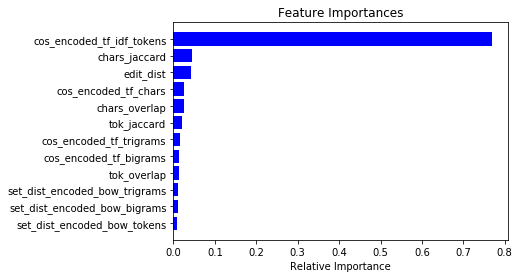

In [186]:
from sklearn.ensemble import RandomForestRegressor

class RandomForestModel(Model):
    def __init__(self, *kwargs):
        self.name = 'RandomForestModel'
        self.description = 'RandomForestModel'    
        super().__init__(*kwargs)
        self.regr = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=1)
        
    def _extract_features(self, x):
        return x

randomForestModel = RandomForestModel(pd.DataFrame(features_train).values, train_labels)
print(randomForestModel.cross_validate())

import matplotlib.pyplot as plt
%matplotlib inline
importances = randomForestModel.regr.feature_importances_
indices = np.argsort(importances)
names = list(features_train[0].keys())

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [187]:
from sklearn.ensemble import GradientBoostingRegressor
class GradientBoostingModel(Model):
    def __init__(self, *kwargs):
        self.name = 'GradientBoostingModel'
        self.description = 'GradientBoostingModel'    
        super().__init__(*kwargs)
        self.regr = GradientBoostingRegressor(alpha=0.95,
                                n_estimators=56, max_depth=4,
                                learning_rate=.101, min_samples_leaf=9, max_features=11,
                                min_samples_split=30, random_state=40)
        
    def _extract_features(self, x):
        return x

gradientBoostingModel = GradientBoostingModel(pd.DataFrame(features_train).values, train_labels)
print(gradientBoostingModel.cross_validate())

0.7194348543631532


In [188]:
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

class SVMModel(Model):
    def __init__(self, *kwargs):
        self.name = 'SVMModel'
        self.description = 'SVMModel'    
        super().__init__(*kwargs)
        self.regr = SVR(C=1.4, epsilon=0.0, gamma='scale')
        
    def _extract_features(self, x):
        return x

    
class GradientBoostingModel(Model):
    def __init__(self, *kwargs):
        self.name = 'GradientBoostingModel'
        self.description = 'GradientBoostingModel'    
        super().__init__(*kwargs)
        self.regr = GradientBoostingRegressor(alpha=0.95,
                                n_estimators=56, max_depth=4,
                                learning_rate=.101, min_samples_leaf=9, max_features=11,
                                min_samples_split=30, random_state=40)
        
    def _extract_features(self, x):
        return x


class RandomForestModel(Model):
    def __init__(self, *kwargs):
        self.name = 'RandomForestModel'
        self.description = 'RandomForestModel'    
        super().__init__(*kwargs)
        self.regr = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=1)
        
    def _extract_features(self, x):
        return x



gradientBoostingModel = GradientBoostingModel(pd.DataFrame(features_train).values, train_labels)
sVMModel = SVMModel(pd.DataFrame(features_train).values, train_labels)
randomForestModel = RandomForestModel(pd.DataFrame(features_train).values, train_labels)


randomForestModel.fit(pd.DataFrame(features_train).values, train_labels)
sVMModel.fit(pd.DataFrame(features_train).values, train_labels)
gradientBoostingModel.fit(pd.DataFrame(features_train).values, train_labels)


pred1 = sVMModel.predict(pd.DataFrame(features_test).values)
pred2 = gradientBoostingModel.predict(pd.DataFrame(features_test).values)
pred3 = randomForestModel.predict(pd.DataFrame(features_test).values)


pred = (pred1+pred2+pred3)
print('Test:', gradientBoostingModel.evaluate(test_labels, pred)[0])

Test: 0.7527692441079573


# Conclusions

We have built a semantic textual similarity system that is able to effectively detect paraphrases (and distinguish them from unrelated sentences), as shown by the fact that we would have ranked the 11th in the original task. Even if we were skeptical that a pure classical NLP approach combined with machine learning would be effective, we have convinced ourselves that it was possible.

We have explored both lexical dimensions (most of the features) and syntatic dimension (for instance, noun phrases). The latter didn't work as expected. Combining the most promising features was key to success, regardless of the particular machine learning algorithm.

We were inspired both by the practical sessions of this course and the ideas suggested by the original participants, as well as the references that we have cited at the end of thsi Notebook. For instance, we saw that using trigrams could be an interesting idea. From the winner, we took the idea that some sentences were almost literally the same one and could be interesting to heuristically detect these cases, although we implemented it with edit distance.

Remarkably, the winners used a plain linear regression. Their feature engineering was that powerful that even the simplest model could grasp the complexity of the dataset. 


## References 

SemEval-2012 Task 6: A Pilot on Semantic Textual Similarity (Eneko Agirre, Daniel Cer, Mona Diab, Aitor Gonzalez-Agirre) 

Computational models for semantic textual similarity (González Aguirre, Aitor, 2017)

Corpus-based and Knowledge-based Measures of Text Semantic Similarity (Ms. Anjali Ganesh Jivani).

Majumder, Goutam & Pakray, Dr. Partha & Gelbukh, Alexander & Pinto, David. (2016). Semantic Textual Similarity Methods, Tools, and Applications: A Survey. Computacion y Sistemas. 20. 647-665. 10.13053/CyS-20-4-2506. 

## Addendum: A note on the use of transfer learning approaches
On parallel with the development of this project with classical NLP methods and classical machine learning, we investigated the use of deep learning for NLP. Specifically, we investigated the use of transfer learning from pre-trained models. Using Facebook's FastText word embeddings (which take characters into account), taking the average of all the word embeddings in a sentence and then applying cosine similarity with the one coming from the other sentence gave us a strong baseline (for only using one feature): 0.62 on cross-validation.

We investigated and did some prelinary experiments with contextual embeddings, specifically vanilla BERT and RoBERTa. Their problem is that they are thought for being used in a token-level manner, but the embeddings can still be averaged, or we can add an additional layer and fine-tune the model.

A recent model, Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks: https://arxiv.org/abs/1908.10084, modifies BERT such that it is able to produce more effective sentence embeddings.

We include the code for achieving the 0.62 correlation only with word embeddings. If we add this feature to our model, we will achieve a better punctuation for sure, but we considered that it did not make sense to apply transfer learning if we had already achieved good results.

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip --directory-prefix=data
%cd data
!unzip wiki-news-300d-1M.vec.zip
%cd ..

import os
import numpy as np
from nltk import word_tokenize
train_tokens = [word_tokenize(sent1) + word_tokenize(sent2) for sent1, sent2 in train_data]
vocabulary = set([])
for tokenized in train_tokens:
    for token in tokenized:
        vocabulary.add(token)
pretrained_embeddings_path = os.path.join('data', 'wiki-news-300d-1M.vec')
needed_tokens = set()
embedding_table = {}
dim = 0
for line in open(pretrained_embeddings_path, 'r').readlines():
    if dim == 0:
        dim = int(line.split()[1])
        continue
    row = line.split()
    token = row[0]
    if token not in vocabulary:
        continue
    vector = np.array(list(map(float, row[1:])))
    embedding_table[token] = vector

import os
import numpy as np
from nltk import word_tokenize
import scipy
import sklearn

from nltk.corpus import stopwords
import string
 
stop_words = set(stopwords.words('english'))

class WordEmbeddingsModel(Model):
    
    
    def __init__(self, embedding_table, dim, method, *kwargs):
        assert method in ['avg', 'sum', 'max']
        self.embedding_table = embedding_table
        self.dim = dim
        self.method = method
        super().__init__(*kwargs)
    
    def _get_sentence_embedding(self, sent):
        tokenized = word_tokenize(sent)
        def contains_punct(token):
            for c in string.punctuation:
                if c in token:
                    return True
            return False
        tokenized = [token for token in tokenized if not contains_punct(token)] # empitjora
        tokenized = [token.lower() for token in tokenized if token.lower() not in stop_words] # empitjora
        embeddings = np.zeros((len(tokenized), self.dim))
        for idx, token in enumerate(tokenized):
            if token in embedding_table:
                embeddings[idx] = self.embedding_table[token]
            else:
                embeddings[idx] = np.zeros(dim)       
        if self.method == 'avg':
            aggregated_embeddings = np.mean(embeddings, axis=0)
        elif self.method == 'sum':
            aggregated_embeddings = np.sum(embeddings, axis=0)
        elif self.method == 'max':
            aggregated_embeddings = np.max(embeddings, axis=0)
        return aggregated_embeddings
    
    def _get_embeddings_and_cosine_similarity(self, sent1, sent2):
        
        emb1 = self._get_sentence_embedding(sent1)
        emb2 = self._get_sentence_embedding(sent2)
        cos_sim = scipy.spatial.distance.cosine(emb1, emb2)
        emb1_emb2 = np.concatenate([emb1, emb2])
        return cos_sim, emb1_emb2

        
    def _extract_features(self, x):
        pass

class NegatedModel():
        def fit(self, X, y):
            return self
        def predict(self, X):
            pred = []
            for row in X:
                pred.append(-row[0])
            return pred

class WordEmbeddingsCosineSimilarityModel(WordEmbeddingsModel):
    def __init__(self, *kwargs):
        super().__init__(*kwargs)
        self.regr = NegatedModel()
        self.name = 'WordEmbeddingsCosineSimilarityModel'
        self.description = 'Pre-trained word Embeddings + stop words and punctuation filtering + cosine sim'
        
    def _extract_features(self, x):
        return np.array([[self._get_embeddings_and_cosine_similarity(sent1, sent2)[0]] for sent1, sent2 in x])

wordEmbeddingsCosineSimilarityModel = WordEmbeddingsCosineSimilarityModel(
    embedding_table, dim, 'avg', train_data, train_labels)
wordEmbeddingsCosineSimilarityModel.cross_validate()